# Pre-processing Finished -> AE_CNN

### Import and Pre-process the Data (data.nzp file with {'X_train': _____ , 'y_train': _____ , 'X_valid': _____ , 'y_valid': _____ })

In [3]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
import tensorflow as tf
tf.__version__

'1.14.0'

In [4]:
pt = 28

In [5]:
data = np.load('/Users/Giatti/Desktop/AI篆刻/ImageMoments/data.npz')
print('Shape of X_train:', data['X_train'].shape) # there are 34 Songti characters for training, with shape (34,784)
print('Shape of y_train:', data['y_train'].shape) # there are 34 STHeiti Medium for training, with shape (34,784)

# print(data['X_train'][0])
train_A = data['X_train'].astype("int8")
train_B = data['y_train'].astype("int8")
train_A, train_B = shuffle(train_A, train_B, random_state = 1234) #

valid_A = data['X_valid'].astype("int8")
valid_B = data['y_valid'].astype("int8")
valid_A, valid_B = shuffle(valid_A, valid_B, random_state = 1234)
print('Shape of train_A and train_B:', train_A.shape)
print('Shape of valid_A and valid_B:', valid_A.shape)

Shape of X_train: (6500, 784)
Shape of y_train: (6500, 784)
Shape of train_A and train_B: (6500, 784)
Shape of valid_A and valid_B: (1300, 784)


In [37]:
from tensorflow.contrib.layers import fully_connected
from tensorflow.python.ops.nn import relu, sigmoid

In [38]:
# define in/output size
num_features = train_A.shape[1]

# reset graph
reset_default_graph()

# define the model
A = tf.placeholder(tf.float32, [None, num_features], 'A')
B = tf.placeholder(tf.float32, [None, num_features], 'B')
l_enc = fully_connected(inputs=A, num_outputs=128, activation_fn=relu, scope='l_enc')
l_z = fully_connected(inputs=l_enc, num_outputs=2, activation_fn=None, scope='l_z') # None indicates a linear output.
l_dec = fully_connected(inputs=l_z, num_outputs=128, activation_fn=relu, scope='l_dec')
A_hat = fully_connected(inputs=l_dec, num_outputs=num_features, activation_fn=sigmoid) # iid pixel intensities between 0 and 1.

# calculate loss
# loss_per_pixel = tf.square(tf.subtract(A_hat, B))
loss_per_pixel = tf.square(tf.subtract(A_hat,  B))
loss = tf.reduce_mean(loss_per_pixel, name="mean_square_error")

# define our optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)

# make training op for applying the gradients
train_op = optimizer.minimize(loss)

In [39]:
# test the forward pass
_A_test = np.zeros(shape=(32, num_features))
_B_targets = np.zeros(shape=(32, num_features))
# initialize the Session
sess = tf.Session()
# test the forward pass
sess.run(tf.initialize_all_variables())
feed_dict = {A: _A_test, B: _B_targets}
res_forward_pass = sess.run(fetches=[A_hat, loss], feed_dict=feed_dict)
print("A_hat", res_forward_pass[0].shape)
print(loss)

A_hat (32, 784)
Tensor("mean_square_error:0", shape=(), dtype=float32)


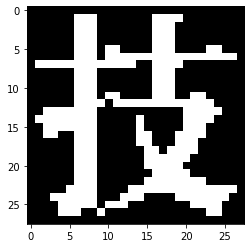

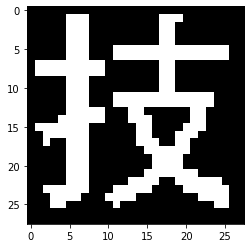

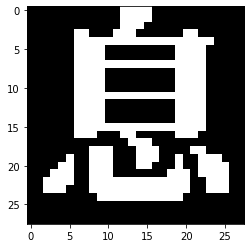

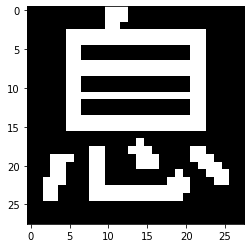

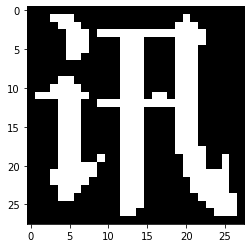

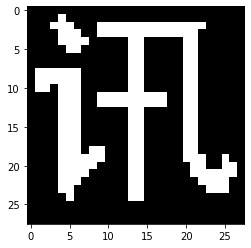

In [9]:
# # testing1 
valid_A[:] = train_A[3]
valid_B[:] = train_B[3]
plt.imshow(valid_A[0].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(valid_B[0].reshape(28,28),cmap='gray')
plt.show()
k=5
size = train_A.shape[0]//k
train_A[size*k:]= train_A[k-1] 
train_B[size*k:]= train_B[k-1] 
for i in range (k-1,0,-1):
    train_A[size*(i-1): size*i] = train_A[i-1]
    train_B[size*(i-1): size*i] = train_B[i-1]
    
plt.imshow(train_A[0].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(train_B[0].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(train_A[102].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(train_B[102].reshape(28,28),cmap='gray')
plt.show()


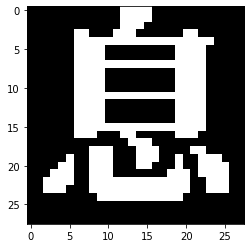

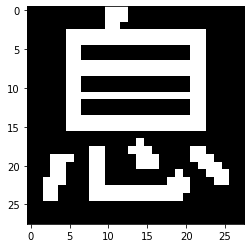

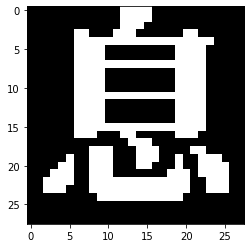

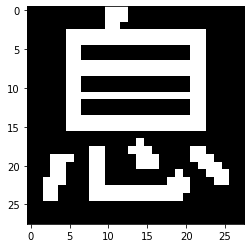

In [20]:
# testing2
valid_A = train_A
valid_B = train_B
plt.imshow(valid_A[0].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(valid_B[0].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(train_A[0].reshape(28,28),cmap='gray')
plt.show()
plt.imshow(train_B[0].reshape(28,28),cmap='gray')
plt.show()

In [42]:
# testing3
train_A = train_A[:5]
train_B = train_B[:5]
valid_A = train_A
valid_B = train_B

(5, 784)

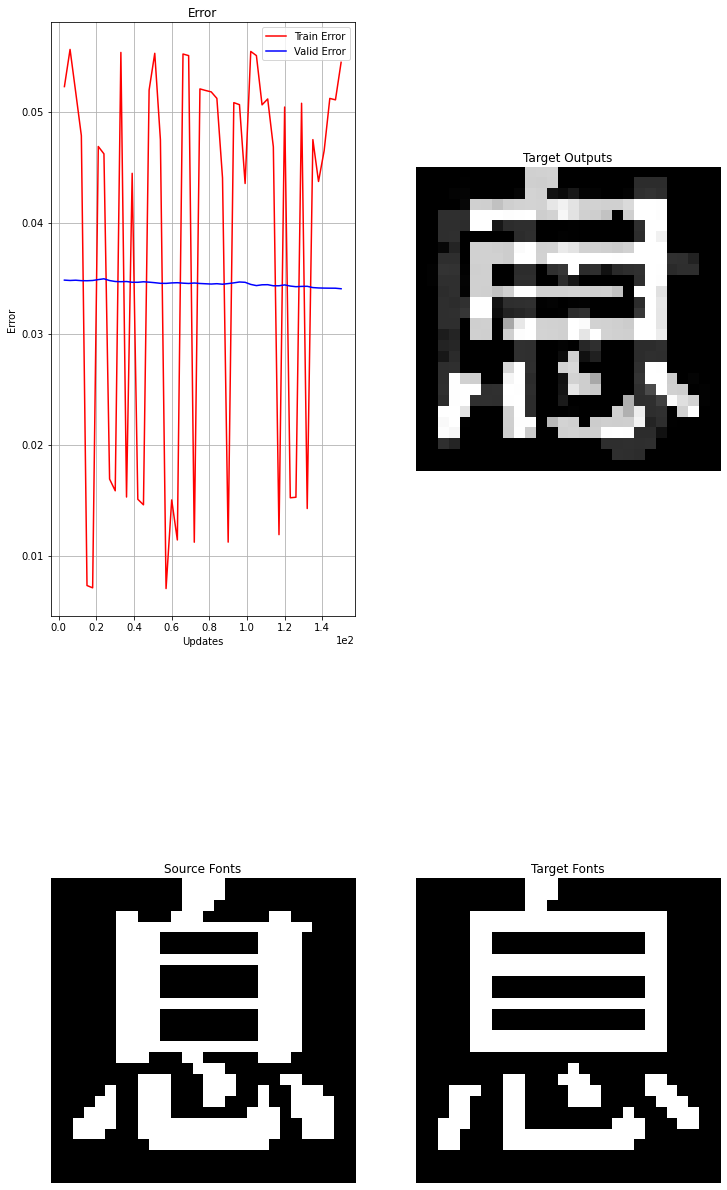

In [48]:
batch_size = 3
num_epochs = 50
num_samples_train = train_A.shape[0] # 206
num_batches_train = num_samples_train // batch_size
# num_samples_valid = valid_A.shape[0] # 148
# num_batches_valid = num_samples_valid // batch_size
updates = []

train_loss = []
valid_loss = []
cur_loss = 0
reset_default_graph()
plt.figure(figsize=(12, 24))

num_char_dim = 1


try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = []
        for i in range(num_batches_train):
            idxs = np.random.choice(range(train_A.shape[0]), size=(batch_size), replace=False)    
            x_A_batch = train_A[idxs]
            x_B_batch = train_B[idxs]
            # setup what to fetch, notice l
            fetches_train = [train_op, loss, A_hat, l_z]
            feed_dict_train = {A: x_A_batch, B: x_B_batch}    # --------------------
            # do the complete backprob pass
            res_train = sess.run(fetches_train, feed_dict_train)
            _, batch_loss, train_out, train_z = tuple(res_train)
            cur_loss += [batch_loss]
        train_loss += [np.mean(cur_loss)]
        updates += [batch_size*num_batches_train*(epoch+1)] # batch_size*num_batches_train =num_samples_train

        # Evaluate     # train_op not used for optimizing!!!
        fetches_eval = [loss, A_hat, l_z]
        ##################### select the valid set #####################
        feed_dict_eval = {A: valid_A, B: valid_B}      # -----------------------
        res_valid = sess.run(fetches_eval, feed_dict_eval)       
        eval_loss, eval_out, eval_z = tuple(res_valid)
        valid_loss += [eval_loss]

        if epoch == 0:
            continue

        # Plotting
        plt.subplot(2,2,1)
        plt.cla() # clear the plot on the this(current) figure
        plt.title('Error')
        plt.xlabel('Updates'); plt.ylabel('Error')
        plt.plot(updates, train_loss, color="red")
        plt.plot(updates, valid_loss, color="blue")
        plt.legend(['Train Error', 'Valid Error'])
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')

        plt.subplot(2,2,2)
        plt.cla()
        plt.title("Target Outputs")
        plt.axis('off')
        idx = 0
        canvas = np.zeros((pt*num_char_dim, num_char_dim*pt))
        for i in range(num_char_dim):
            for j in range(num_char_dim):
                canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = eval_out[idx].reshape((pt, pt))
                idx += 1
        plt.imshow(canvas, cmap='gray')
        
        plt.subplot(2,2,3)
        plt.cla()
        plt.title("Source Fonts")
        plt.axis('off')
        idx = 0
        canvas = np.zeros((pt*num_char_dim, num_char_dim*pt))
        for i in range(num_char_dim):
            for j in range(num_char_dim):
                canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = valid_A[idx].reshape((pt, pt))
#                 canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = train_A[idx].reshape((pt, pt))
                idx += 1
        plt.imshow(canvas, cmap='gray')
                
        plt.subplot(2,2,4)
        plt.cla()
        plt.title("Target Fonts")
        plt.axis('off')
        idx = 0
        canvas = np.zeros((pt*num_char_dim, num_char_dim*pt))
        for i in range(num_char_dim):
            for j in range(num_char_dim):
                canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = valid_B[idx].reshape((pt, pt))
#                 canvas[i*pt:(i+1)*pt, j*pt:(j+1)*pt] = train_B[idx].reshape((pt, pt))
                idx += 1
        plt.imshow(canvas, cmap='gray')
        
        plt.savefig("output.png")
        display(Image(filename="output.png"))
        clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [31]:
print(A_hat.shape)

(?, 784)


In [32]:
np.mean(np.square(train_A[0]-train_B[0]))

0.17091836734693877